In [1]:
# PATH = r'/Users/Arapidis/Documents/Projects/nCoV2019/ModelsFiles'
# ending = 'xlsx'
# g = glob.glob(os.path.join(PATH, f'*.{ending}'))
# for i in g:
#     print(i.split('/')[-1])

In [2]:
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from jupyterthemes import jtplot
import pickle
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import time

import lmfit
from sklearn.preprocessing import FunctionTransformer
import math
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split


import requests
from bs4 import BeautifulSoup
import git

jtplot.style()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)
pd.set_option('display.expand_frame_repr', False)

/Users/Arapidis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



If the cell above gives any errors for missing packages, simply:
`!pip install PACKAGE`,

where `PACKAGE` is the missing package, e.g. for git: it's 

`!pip install GitPython`

# Update data

check remote git:
    
`git remote show origin`

In [3]:
git_dir = r'./COVID-19/'

g = git.cmd.Git(git_dir)
print(g.branch('-a'))
g.fetch()
g.pull()

  0a
* master
  web-data
  remotes/origin/CSSEGISandData-patch-02042020
  remotes/origin/HEAD -> origin/master
  remotes/origin/master
  remotes/origin/web-data


'Updating db4efa2b..3377100d\nFast-forward\n README.md                                          |   18 +-\n csse_covid_19_data/README.md                       |   36 +-\n csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv   |   21 +\n .../csse_covid_19_daily_reports/04-21-2020.csv     |   12 +-\n .../csse_covid_19_daily_reports/04-22-2020.csv     | 3100 ++++++++++\n .../csse_covid_19_daily_reports/04-23-2020.csv     | 3121 ++++++++++\n .../csse_covid_19_daily_reports/04-24-2020.csv     | 3129 ++++++++++\n .../csse_covid_19_daily_reports/04-25-2020.csv     | 3135 ++++++++++\n .../csse_covid_19_daily_reports/04-26-2020.csv     | 3143 ++++++++++\n .../csse_covid_19_daily_reports/04-27-2020.csv     | 3153 ++++++++++\n .../csse_covid_19_daily_reports/04-28-2020.csv     | 3164 ++++++++++\n .../csse_covid_19_daily_reports/04-29-2020.csv     | 3169 ++++++++++\n .../csse_covid_19_daily_reports/04-30-2020.csv     | 3178 ++++++++++\n .../csse_covid_19_daily_reports/05-01-2020.csv     | 3189 +++++++

# Create the dataframe from the different files

In [4]:
# dates of measures
# https://www.dw.com/en/coronavirus-what-are-the-lockdown-measures-across-europe/a-52905137

minor_measures = {
    'United Kingdom':'2020-03-17',
    'US':'2020-03-15'
}

nationwide_measures = {
    'China':'2020-01-23',
    'Greece':'2020-03-15',
    'Italy':'2020-03-09',
    'Spain':'2020-03-14',
    'France':'2020-03-17',
    'Costa Rica':'2020-03-16',
    'Luxembourg':'2020-03-16',
    'Czechia':'2020-03-16',
    'United Kingdom':'2020-03-23',
    'Belgium':'2020-03-18',
    'Germany':'2020-03-22',
    'Austria':'2020-03-16'
}

In [5]:
ending = 'csv'
path_to_files = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'
# path_to_files = r'./COVID-19/data'
all_paths = glob.glob(os.path.join(path_to_files, f'*.{ending}'))

In [6]:
all_paths

['./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/Errata.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv']

In [7]:
paths_global = [_ for _ in all_paths if 'global' in _]

In [8]:
paths_global

['./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

In [9]:
df_list = list()

for f in paths_global:
    foo = pd.read_csv(f)
    foo = pd.melt(foo, id_vars=[
                  'Province/State', 'Country/Region', 'Lat', 'Long'], var_name=['Date'])
    foo['Date'] = pd.to_datetime(foo['Date'])
    foo.columns = foo.columns.str.replace(
        'value', f.split("_")[-2].capitalize())
    foo['Province/State'].fillna(foo['Country/Region'], inplace=True)
    foo.set_index(['Province/State', 'Country/Region',
                   'Date', 'Lat', 'Long'], inplace=True)
    df_list.append(foo)

In [10]:
df = pd.concat(df_list, axis = 1).reset_index()
df.shape

(28840, 8)

In [11]:
europe = dict()
population_europe = dict()
URL = "https://en.wikipedia.org/wiki/Member_state_of_the_European_Union"

res = requests.get(URL).text
soup = BeautifulSoup(res,'lxml')
for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
    data = items.find_all(['th','td'])
    try:
        country = data[0].a.text
        pop = int(data[2].text.split('[')[0].replace(',', ''))
        europe[country] = 'EU'
        population_europe[country] = pop
    except IndexError:
        pass

In [12]:
# Save to pickle

# with open('country_continent.pickle', 'wb') as handle:
#     pickle.dump(country_continent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Read pickle
with open('country_continent.pickle', 'rb') as handle:
    country_continent = pickle.load(handle)

In [14]:
df2 = df.copy()
df2['Date_1'] = df2['Date'] + pd.Timedelta(days=1)
df2.rename(columns={'Confirmed': 'Confirmed_1',
                    'Deaths': 'Deaths_1',
                    'Recovered': 'Recovered_1',
                    'Date': 'Date_Minus_1'}, inplace=True)

In [15]:
df3 = df.merge(df2[['Province/State',
                    'Country/Region',
                    'Confirmed_1',
                    'Deaths_1',
                    'Recovered_1',
                    'Date_1',
                    'Date_Minus_1']], how='left',
               left_on=['Province/State', 'Country/Region', 'Date'],
               right_on=['Province/State', 'Country/Region', 'Date_1'])

In [16]:
df3['ConfirmedDaily'] = df3['Confirmed'] - df3['Confirmed_1']
df3['DeathsDaily'] = df3['Deaths'] - df3['Deaths_1']
df3['RecoveredDaily'] = df3['Recovered'] - df3['Recovered_1']

In [17]:
df3['ConfirmedDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Confirmed']
df3['DeathsDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Deaths']
df3['RecoveredDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Recovered']

del df3['Confirmed_1']
del df3['Deaths_1']
del df3['Recovered_1']
del df3['Date_1']
del df3['Date_Minus_1']

/Users/Arapidis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
print(f'Deaths:\t\t{df3.DeathsDaily.sum()}\nConfirmed:\t{df3.ConfirmedDaily.sum()}\nRecovered:\t{df3.RecoveredDaily.sum()}\nCountries:\t{len(df3["Country/Region"].unique())}')

Deaths:		247470.0
Confirmed:	3506729.0
Recovered:	1125236.0
Countries:	187


In [19]:
df3['MonthYear'] = df3['Date'].dt.strftime('%b-%Y')

In [20]:
df3['Continent'] = df3['Country/Region'].map(country_continent)

In [21]:
if len(df3[df3['Continent'].isna()]) == 0:
    print(30*'+'+' All good ' + 30*'+')
else:
    print(30*'-'+' Check ' + 30*'-')

------------------------------ Check ------------------------------


In [22]:
df3['DeathRate'] = df3['Deaths'] / df3['Confirmed']
df3['RecoveredRate'] = df3['Recovered'] / df3['Confirmed']

In [23]:
df3.groupby(['Country/Region']).sum()[['DeathsDaily']
                                      ].sort_values(ascending=False,
                                                    by='DeathsDaily').reset_index().head(10)

,Country/Region,DeathsDaily
0,US,67682.0
1,Italy,28884.0
2,United Kingdom,28520.0
3,Spain,25264.0
4,France,24900.0
5,Belgium,7844.0
6,Brazil,7051.0
7,Germany,6866.0
8,Iran,6203.0
9,Netherlands,5072.0


In [24]:
df3.groupby(['Country/Region']).sum()[['ConfirmedDaily']
                                      ].sort_values(ascending=False,
                                                    by='ConfirmedDaily').sum()

ConfirmedDaily    3506729.0
dtype: float64

In [25]:
df3.to_csv(f'data_{datetime.date.today()}.csv')

# Plots

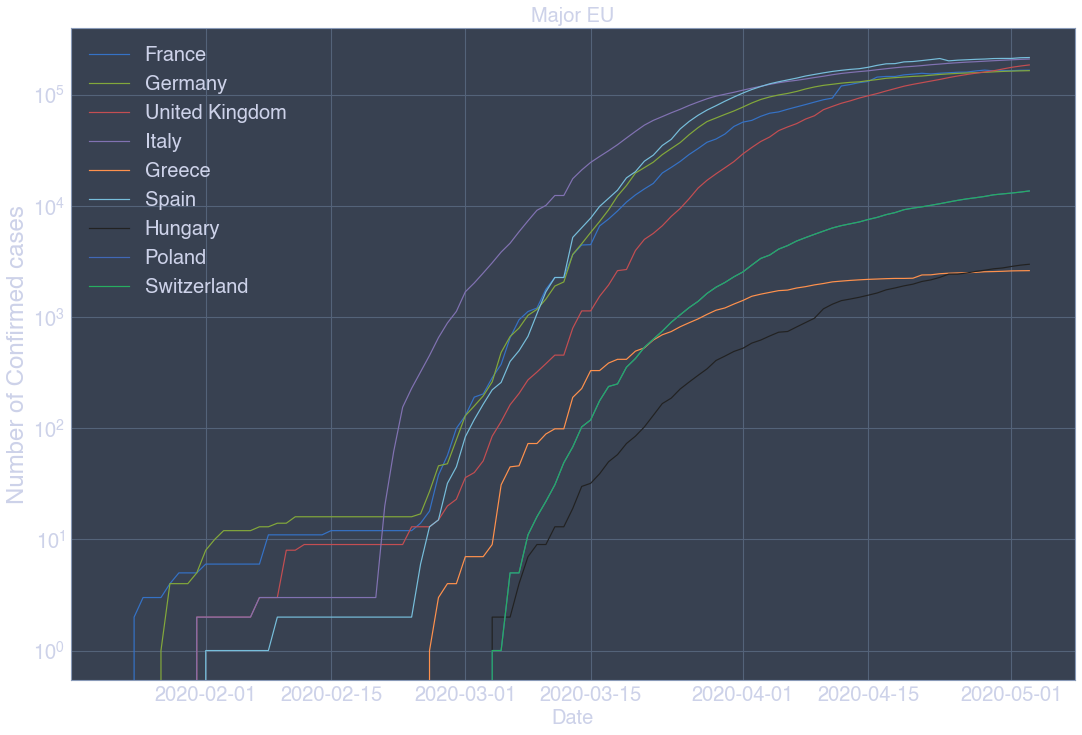

In [26]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']
y8 = df3[df3['Province/State'] == 'Poland']['Confirmed']
y9 = df3[df3['Province/State'] == 'Switzerland']['Confirmed']




plt.figure(figsize = (18, 12))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')
plt.semilogy(x, y8, label = 'Poland')
plt.semilogy(x, y8, label = 'Switzerland')


plt.xlabel('Date', fontsize = 20)
plt.title('Major EU', fontsize = 20)
plt.ylabel('Number of Confirmed cases', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.savefig('eu_countries_confirmed.png', dpi = 600, bbox_inches= 'tight')

plt.show()

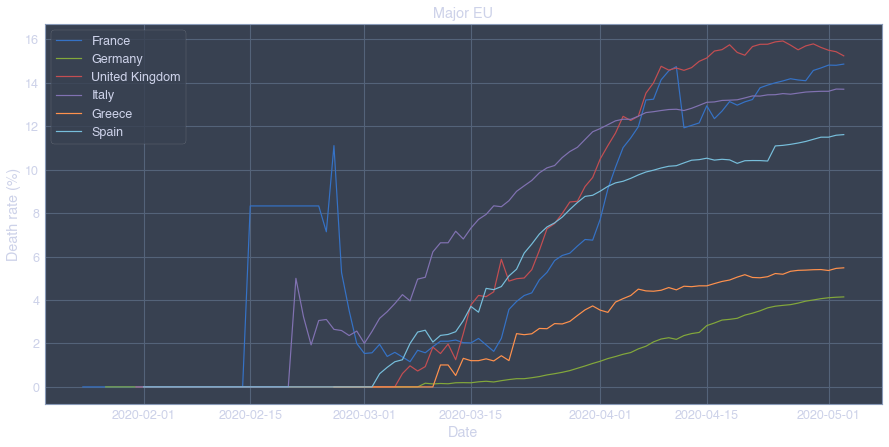

In [27]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['DeathRate'] * 100
y2 = df3[df3['Province/State'] == 'Germany']['DeathRate'] * 100
y3 = df3[df3['Province/State'] == 'United Kingdom']['DeathRate'] * 100
y4 = df3[df3['Province/State'] == 'Italy']['DeathRate'] * 100
y5 = df3[df3['Province/State'] == 'Greece']['DeathRate'] * 100
y6 = df3[df3['Province/State'] == 'Spain']['DeathRate'] * 100




plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'France')
plt.plot(x, y2, label = 'Germany')
plt.plot(x, y3, label = 'United Kingdom')
plt.plot(x, y4, label = 'Italy')
plt.plot(x, y5, label = 'Greece')
plt.plot(x, y6, label = 'Spain')

plt.ylabel('Death rate (%)')
plt.xlabel('Date')
plt.title('Major EU')
plt.legend()
plt.show()

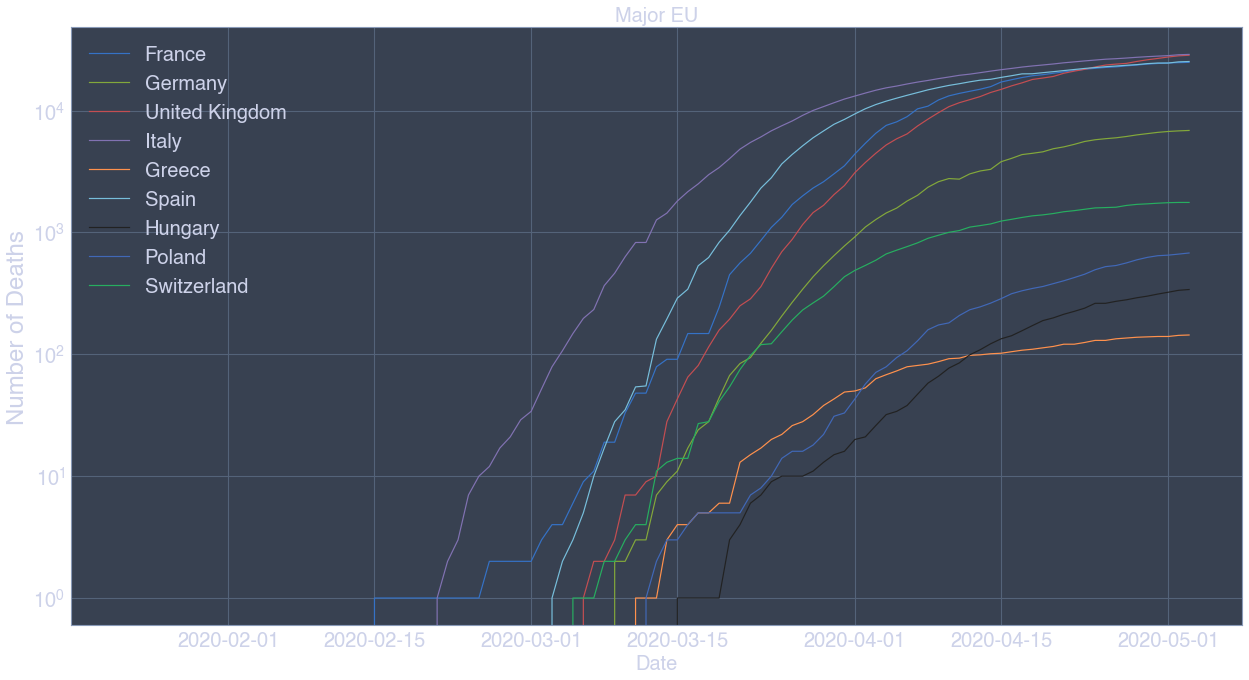

In [28]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Deaths']
y2 = df3[df3['Province/State'] == 'Germany']['Deaths']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y4 = df3[df3['Province/State'] == 'Italy']['Deaths']
y5 = df3[df3['Province/State'] == 'Greece']['Deaths']
y6 = df3[df3['Province/State'] == 'Spain']['Deaths']
y7 = df3[df3['Province/State'] == 'Hungary']['Deaths']
y8 = df3[df3['Province/State'] == 'Poland']['Deaths']
y9 = df3[df3['Province/State'] == 'Switzerland']['Deaths']



plt.figure(figsize = (21, 11))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')
plt.semilogy(x, y8, label = 'Poland')
plt.semilogy(x, y9, label = 'Switzerland')

plt.xlabel('Date', fontsize = 20)
plt.title('Major EU', fontsize = 20)
plt.ylabel('Number of Deaths', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.savefig('eu_countries_deaths.png', dpi = 600, bbox_inches= 'tight')

plt.show()

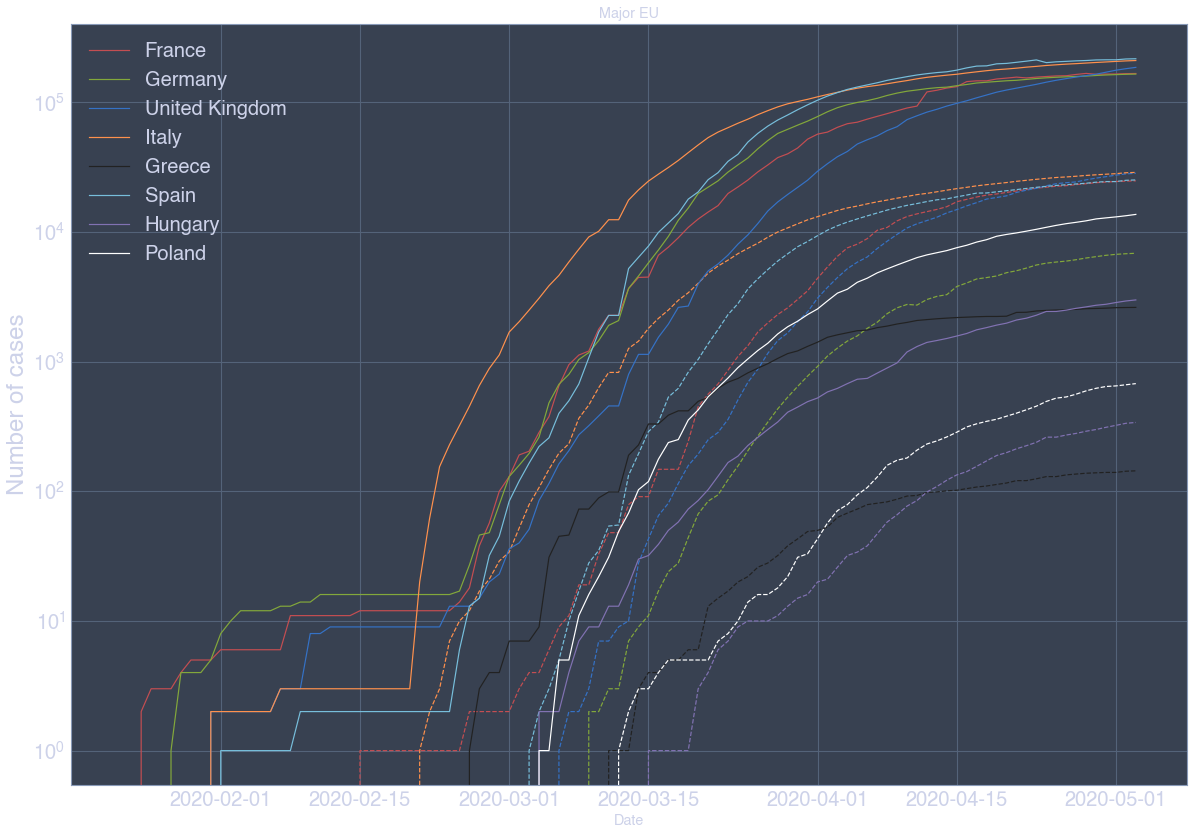

In [29]:
plt.figure(figsize = (20, 14))
x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']
y8 = df3[df3['Province/State'] == 'Poland']['Confirmed']

y12 = df3[df3['Province/State'] == 'France']['Deaths']
y22 = df3[df3['Province/State'] == 'Germany']['Deaths']
y32 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y42 = df3[df3['Province/State'] == 'Italy']['Deaths']
y52 = df3[df3['Province/State'] == 'Greece']['Deaths']
y62 = df3[df3['Province/State'] == 'Spain']['Deaths']
y72 = df3[df3['Province/State'] == 'Hungary']['Deaths']
y82 = df3[df3['Province/State'] == 'Poland']['Deaths']


plt.semilogy(x, y12, '--r')
plt.semilogy(x, y22, '--g')
plt.semilogy(x, y32, '--b')
plt.semilogy(x, y42, '--y')
plt.semilogy(x, y52, '--k')
plt.semilogy(x, y62, '--c')
plt.semilogy(x, y72, '--m')
plt.semilogy(x, y82, '--w')

plt.semilogy(x, y1, '-r', label = 'France')
plt.semilogy(x, y2, '-g', label = 'Germany')
plt.semilogy(x, y3, '-b', label = 'United Kingdom')
plt.semilogy(x, y4, '-y', label = 'Italy')
plt.semilogy(x, y5, '-k', label = 'Greece')
plt.semilogy(x, y6, '-c', label = 'Spain')
plt.semilogy(x, y7, '-m', label = 'Hungary')
plt.semilogy(x, y8, '-w', label = 'Poland')

plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.title('Major EU')
plt.ylabel('Number of cases', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.show()

In [30]:
df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()

,Date,Lat,Long,Confirmed,Recovered,Deaths,ConfirmedDaily,DeathsDaily,RecoveredDaily,DeathRate,RecoveredRate
0,2020-01-22,1083.3367,3684.4197,548.0,28.0,17.0,548.0,17.0,28.0,0.038288,0.063063
1,2020-01-23,1083.3367,3684.4197,643.0,30.0,18.0,95.0,1.0,2.0,1.038288,0.125563
2,2020-01-24,1083.3367,3684.4197,920.0,36.0,26.0,277.0,8.0,6.0,0.793716,0.195236
3,2020-01-25,1083.3367,3684.4197,1406.0,39.0,42.0,486.0,16.0,3.0,0.288674,0.218459
4,2020-01-26,1083.3367,3684.4197,2075.0,49.0,56.0,669.0,14.0,10.0,0.229787,0.152046
5,2020-01-27,1083.3367,3684.4197,2877.0,58.0,82.0,802.0,26.0,9.0,0.226066,0.196584
6,2020-01-28,1083.3367,3684.4197,5509.0,101.0,131.0,2632.0,49.0,43.0,0.152871,0.244761
7,2020-01-29,1083.3367,3684.4197,6087.0,120.0,133.0,578.0,2.0,19.0,0.143970,0.428728
8,2020-01-30,1083.3367,3684.4197,8141.0,135.0,171.0,2054.0,38.0,15.0,0.147556,0.472681
9,2020-01-31,1083.3367,3684.4197,9802.0,214.0,213.0,1661.0,42.0,79.0,0.126393,0.576703


In [31]:
foo = df3.groupby(['Continent', 'Date']).sum().reset_index()

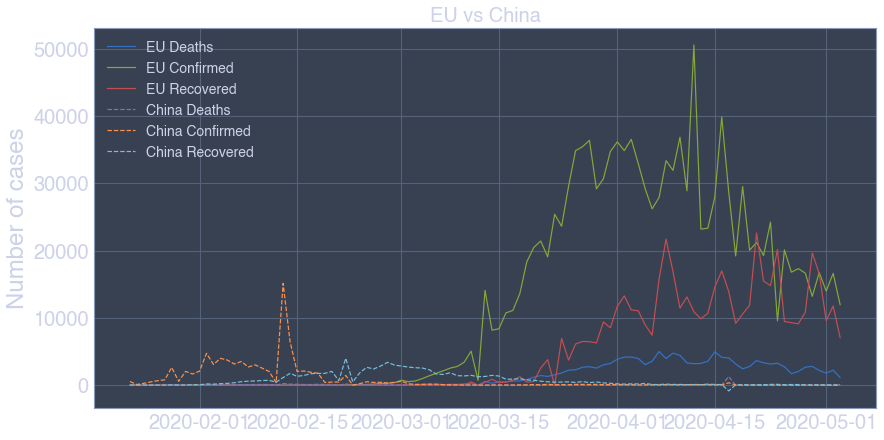

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['DeathsDaily'], label='EU Deaths')
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['ConfirmedDaily'], label='EU Confirmed')
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['RecoveredDaily'], label='EU Recovered')

plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['DeathsDaily'],
         '--', label='China Deaths')
plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['ConfirmedDaily'],
         '--', label='China Confirmed')
plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['RecoveredDaily'],
         '--', label='China Recovered')

plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.show()

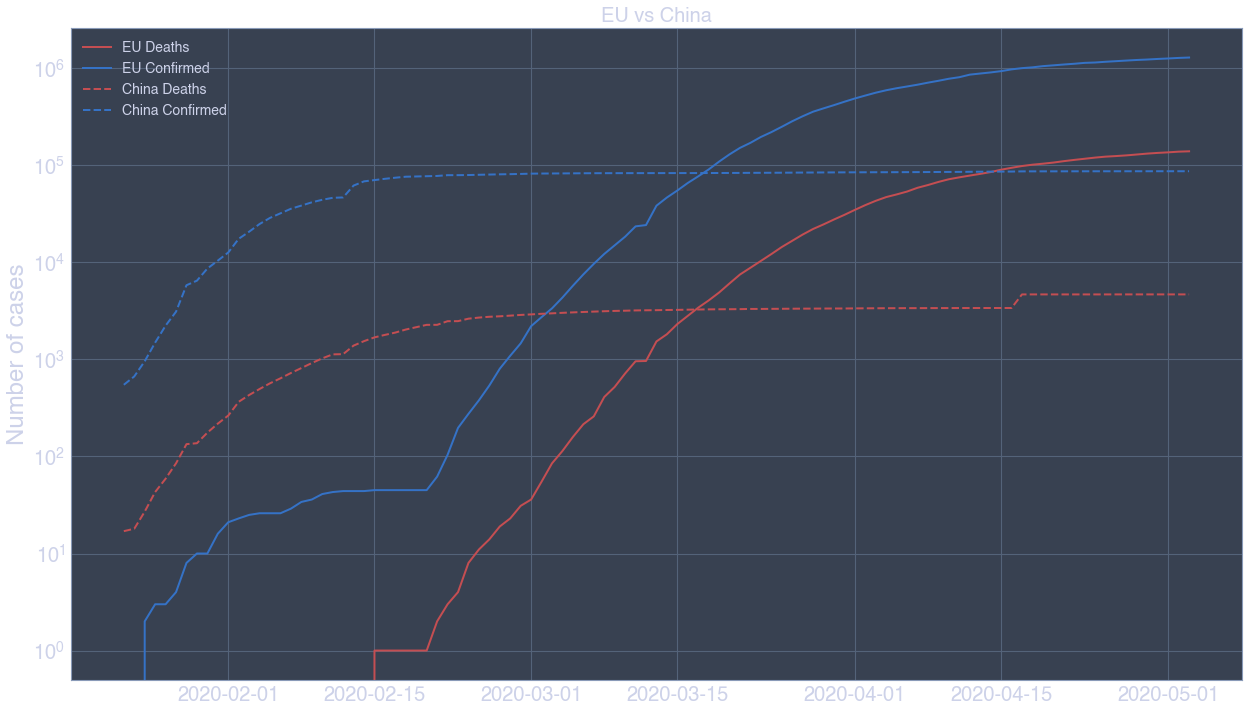

In [33]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-r', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-b',  linewidth=2, markersize=10, label='EU Confirmed')

# plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
#              foo[foo['Continent'] == 'Europe']['Recovered'],
#              '-g', linewidth=2, markersize=10, label='EU Recovered')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b', linewidth=2, markersize=10, label='China Confirmed')

# plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
#              df3[df3['Country/Region'] ==
#                  'China'].groupby('Date').sum().reset_index()['Recovered'],
#              '--g', linewidth=2, markersize=10, label='China Recovered')


plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.savefig('eu_vs_china.png', dpi = 600, bbox_inches= 'tight')

plt.show()

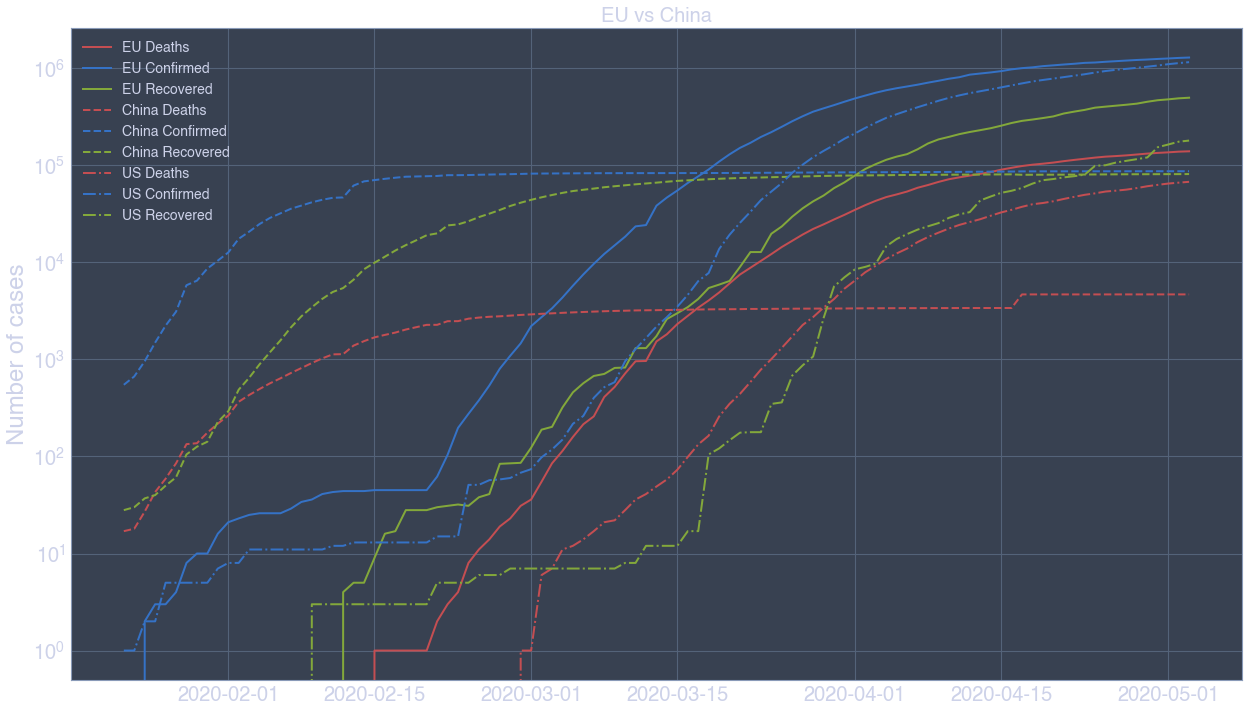

In [34]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-r', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-b',  linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-g', linewidth=2, markersize=10, label='EU Recovered')



plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b',  linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '--g',  linewidth=2, markersize=10, label='China Recovered')



plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Deaths'],
             '-.r', linewidth=2, markersize=10, label='US Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Confirmed'],
             '-.b',  linewidth=2, markersize=10, label='US Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Recovered'],
             '-.g',  linewidth=2, markersize=10, label='US Recovered')


plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.savefig('eu_vs_us_vs_china.png', dpi = 600, bbox_inches= 'tight')
plt.show()

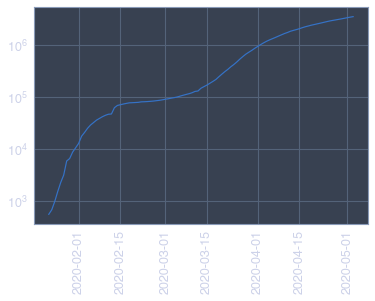

In [35]:
plt.semilogy(df3.groupby('Date').sum().reset_index()['Date'], 
         df3.groupby('Date').sum().reset_index()['Confirmed'])
plt.xticks(rotation = 90)
plt.show()

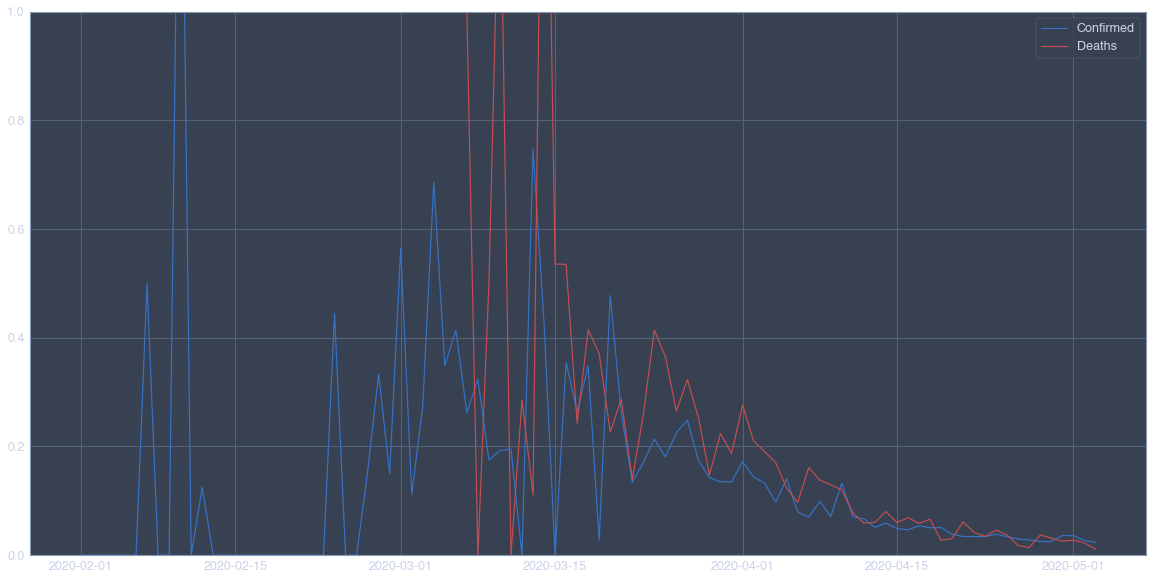

In [36]:
plt.figure(figsize = (20,10))
c = 'United Kingdom'
x = df3[df3['Country/Region'] ==
    c].groupby('Date').sum()[['Confirmed', 'Deaths']].pct_change().index
y = df3[df3['Country/Region'] ==
    c].groupby('Date').sum()[['Confirmed', 'Deaths']].pct_change()['Confirmed']
y2 = df3[df3['Country/Region'] ==
    c].groupby('Date').sum()[['Confirmed', 'Deaths']].pct_change()['Deaths']

plt.plot(x, y, 'b', label = 'Confirmed')
plt.plot(x, y2, 'r', label = 'Deaths')
plt.ylim(0, 1)

plt.legend()
plt.show()

In [37]:
df3.head()

,Province/State,Country/Region,Date,Lat,Long,Confirmed,Recovered,Deaths,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear,Continent,DeathRate,RecoveredRate
0,Afghanistan,Afghanistan,2020-01-22,33.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Asia,NaN,NaN
1,Afghanistan,Afghanistan,2020-01-23,33.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Asia,NaN,NaN
2,Afghanistan,Afghanistan,2020-01-24,33.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Asia,NaN,NaN
3,Afghanistan,Afghanistan,2020-01-25,33.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Asia,NaN,NaN
4,Afghanistan,Afghanistan,2020-01-26,33.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Asia,NaN,NaN


In [38]:
eu = df3[df3['Continent'] == 'Europe']
eu.head()

,Province/State,Country/Region,Date,Lat,Long,Confirmed,Recovered,Deaths,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear,Continent,DeathRate,RecoveredRate
103,Albania,Albania,2020-01-22,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Europe,NaN,NaN
104,Albania,Albania,2020-01-23,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Europe,NaN,NaN
105,Albania,Albania,2020-01-24,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Europe,NaN,NaN
106,Albania,Albania,2020-01-25,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Europe,NaN,NaN
107,Albania,Albania,2020-01-26,41.1533,20.1683,0.0,0.0,0.0,0.0,0.0,0.0,Jan-2020,Europe,NaN,NaN


In [39]:
eu = eu.groupby(['Date', 'Country/Region']
                ).sum()[['Recovered', 'Deaths', 'Confirmed']].reset_index()

In [40]:
eu_confirmed = eu[['Date', 'Country/Region', 'Confirmed']]
eu_deaths = eu[['Date', 'Country/Region', 'Deaths']]

In [41]:
cm_conf = eu_confirmed.pivot(
    index='Date', columns='Country/Region', values='Confirmed').corr()
cm_deaths = eu_deaths.pivot(
    index='Date', columns='Country/Region', values='Deaths').corr()

## Correlation

In [42]:
# plt.matshow(cm_conf)
# plt.show()

In [43]:
# cm_conf.style.background_gradient()

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

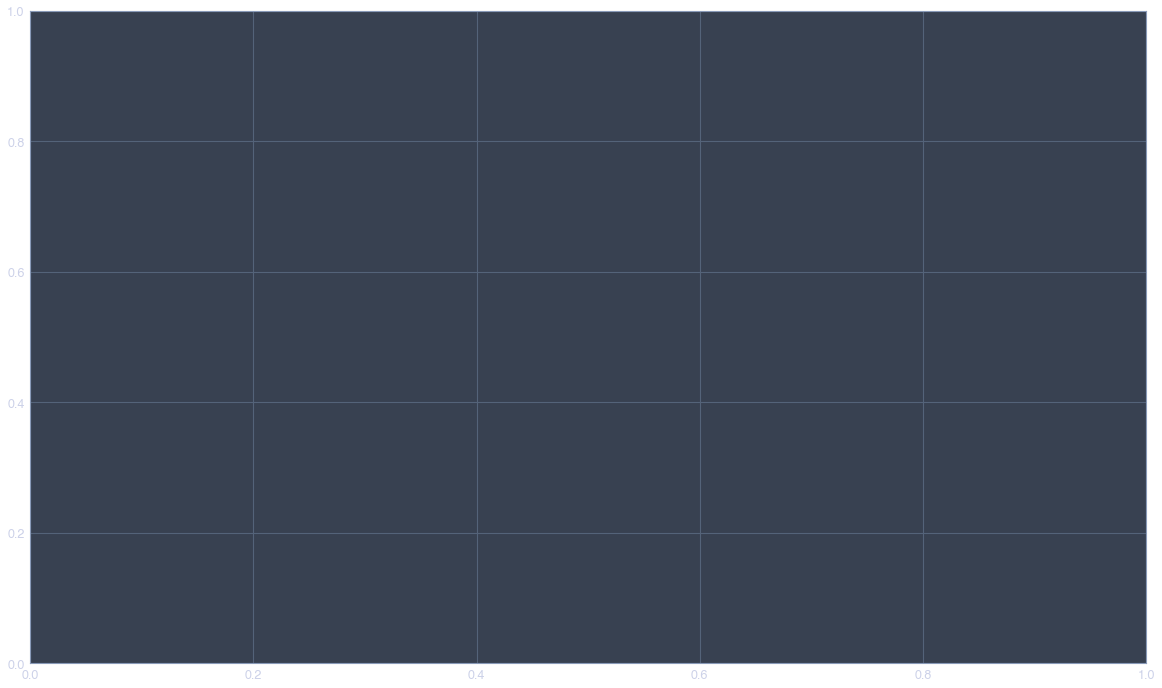

In [44]:
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cm_conf[cm_conf['Italy'] > 0.6][['Italy']],
            mask=np.zeros_like(cm_conf[cm_conf['Italy'] > 0.6][['Italy']],
                               dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.savefig('corr_conf.png', dpi=600, bbox_inches='tight')
plt.show()

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

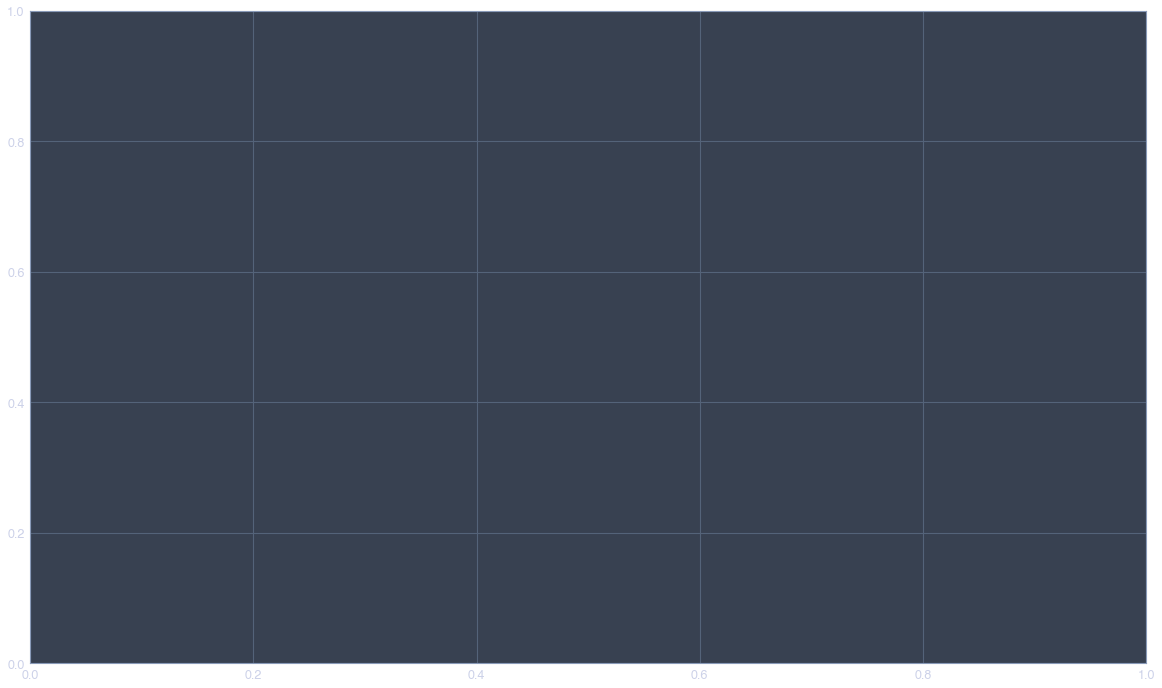

In [45]:
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cm_deaths[cm_deaths['Italy'] > 0.6][['Italy']],
            mask=np.zeros_like(cm_deaths[cm_deaths['Italy'] > 0.6][['Italy']],
                               dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.savefig('corr_deaths.png', dpi=600, bbox_inches='tight')
plt.show()

## Curves

In [46]:
foo = df3[df3['Confirmed'] > 10]

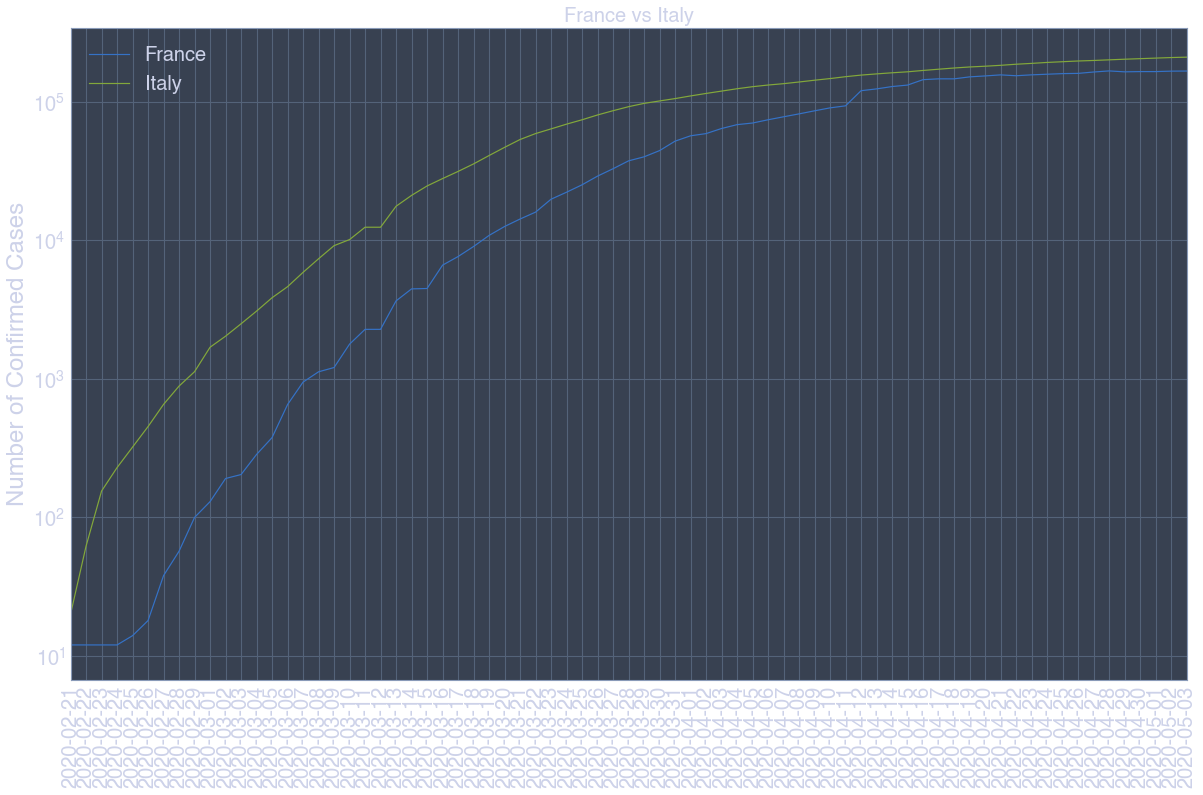

In [47]:

x3 = foo[foo['Province/State'] == 'France']['Date']

x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'France']['Confirmed']
y4 = foo[foo['Province/State'] == 'Italy']['Confirmed']

fig, ax = plt.subplots(figsize = (20,12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)

ax.set_xlim(np.datetime64('2020-02-21'), max(x4))

ax.semilogy(x3, y3, label = 'France')
ax.semilogy(x4, y4, label = 'Italy')


ax.set_title('France vs Italy', fontsize = 20)
ax.set_ylabel('Number of Confirmed Cases', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)
# ax.set_yticks(fontsize=20)


plt.legend(frameon=False, fontsize=20)
plt.savefig('Italy_France.png', dpi = 600, bbox_inches= 'tight')

plt.show()

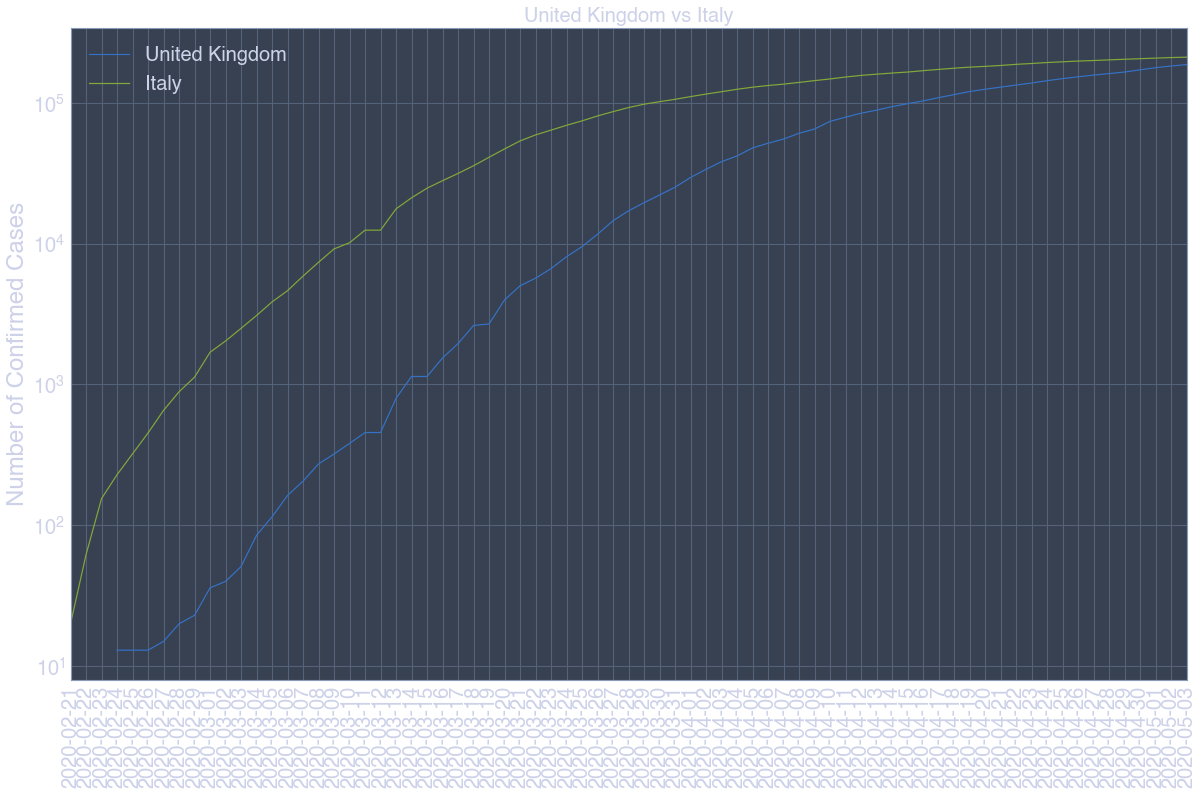

In [48]:
foo = df3[df3['Confirmed'] > 10]
x3 = foo[foo['Province/State'] == 'United Kingdom']['Date']

x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'United Kingdom']['Confirmed']
y4 = foo[foo['Province/State'] == 'Italy']['Confirmed']

fig, ax = plt.subplots(figsize = (20,12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)
ax.set_xlim(np.datetime64('2020-02-21'), max(x4))


ax.semilogy(x3, y3, label = 'United Kingdom')
ax.semilogy(x4, y4, label = 'Italy')


ax.set_title('United Kingdom vs Italy', fontsize = 20)
ax.set_ylabel('Number of Confirmed Cases', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)
# ax.set_yticks(fontsize=20)


plt.legend(frameon=False, fontsize=20)
plt.savefig('Italy_United Kingdom.png', dpi = 600, bbox_inches= 'tight')

plt.show()

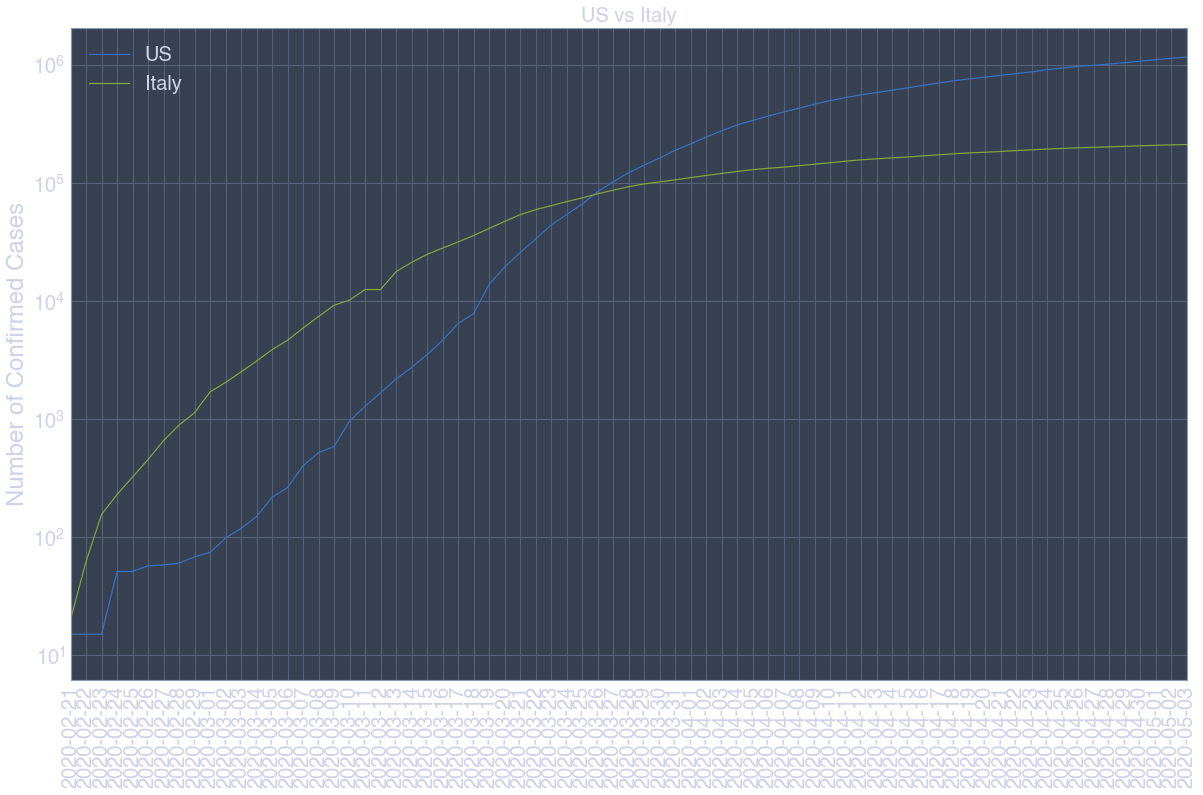

In [49]:
foo = df3[df3['Confirmed'] > 10]
x3 = foo[foo['Province/State'] == 'US']['Date']

x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'US']['Confirmed']
y4 = foo[foo['Province/State'] == 'Italy']['Confirmed']

fig, ax = plt.subplots(figsize = (20,12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)


ax.semilogy(x3, y3, label = 'US')
ax.semilogy(x4, y4, label = 'Italy')

ax.set_xlim(np.datetime64('2020-02-21'), max(x4))

ax.set_title('US vs Italy', fontsize = 20)
ax.set_ylabel('Number of Confirmed Cases', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)
# ax.set_yticks(fontsize=20)


plt.legend(frameon=False, fontsize=20)
plt.savefig('Italy_US.png', dpi = 600, bbox_inches= 'tight')

plt.show()

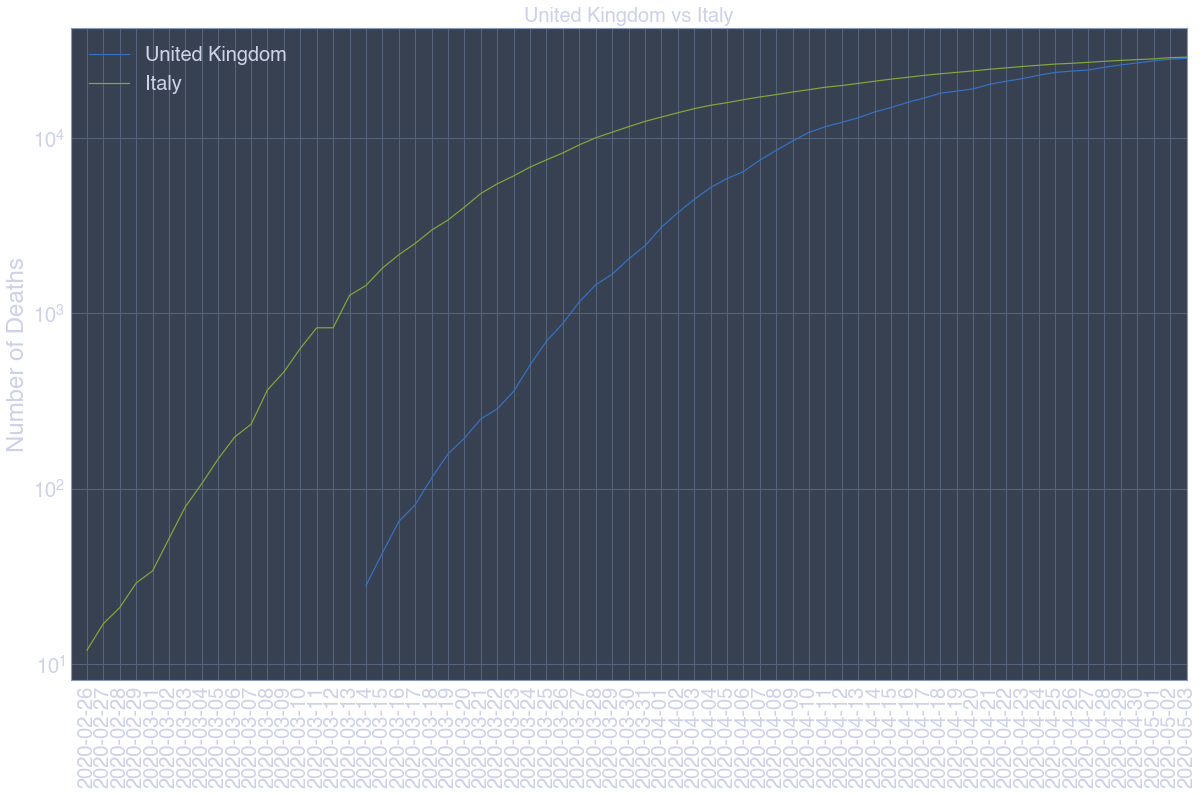

In [50]:
foo = df3[df3['Deaths'] > 10]
x3 = foo[foo['Province/State'] == 'United Kingdom']['Date']

x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'United Kingdom']['Deaths']
y4 = foo[foo['Province/State'] == 'Italy']['Deaths']

fig, ax = plt.subplots(figsize = (20,12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)
ax.set_xlim(np.datetime64('2020-02-25'), max(x4))


ax.semilogy(x3, y3, label = 'United Kingdom')
ax.semilogy(x4, y4, label = 'Italy')


ax.set_title('United Kingdom vs Italy', fontsize = 20)
ax.set_ylabel('Number of Deaths', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)
# ax.set_yticks(fontsize=20)


plt.legend(frameon=False, fontsize=20)
plt.savefig('Italy_United Kingdom_deaths.png', dpi = 600, bbox_inches= 'tight')

plt.show()

In [51]:
pd.to_datetime(nationwide_measures['China'], dayfirst=True).date()

datetime.date(2020, 1, 23)

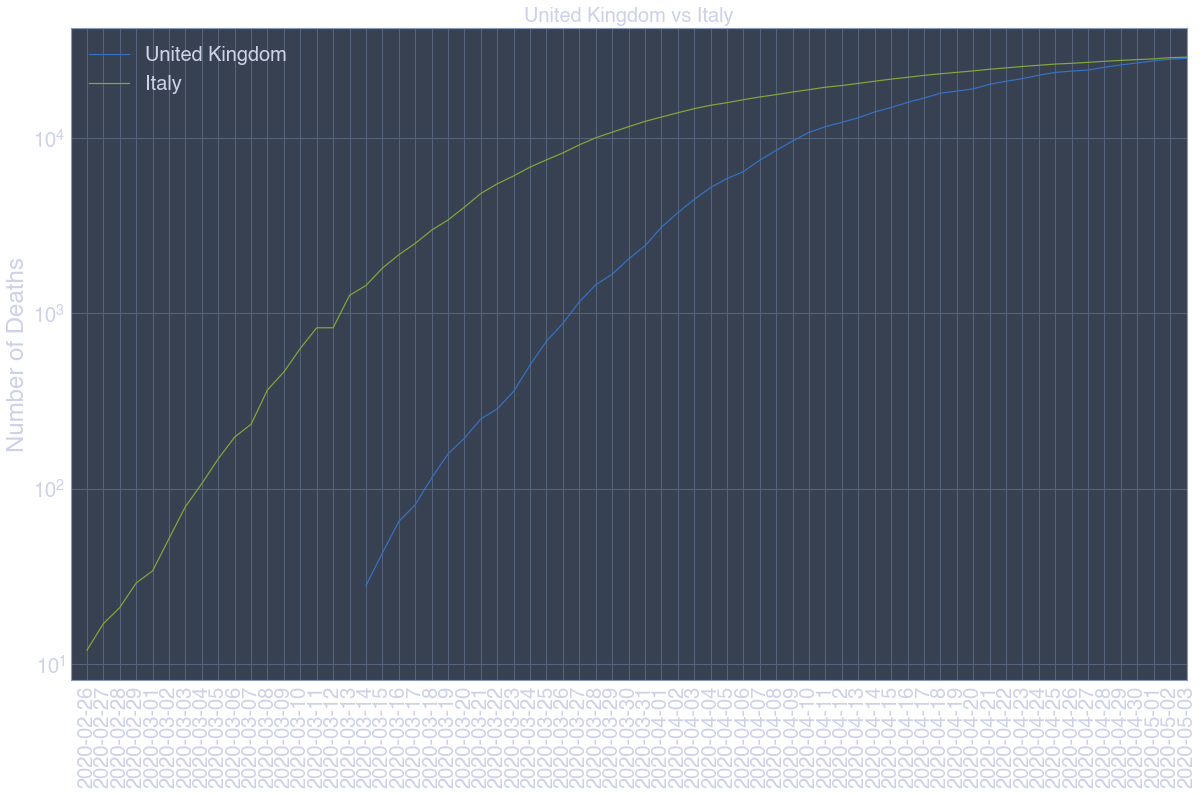

In [52]:
foo = df3[df3['Deaths'] > 10]
x3 = foo[foo['Province/State'] == 'United Kingdom']['Date']

x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'United Kingdom']['Deaths']
y4 = foo[foo['Province/State'] == 'Italy']['Deaths']

fig, ax = plt.subplots(figsize = (20,12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)
ax.set_xlim(np.datetime64('2020-02-25'), max(x4))


ax.semilogy(x3, y3, label = 'United Kingdom')
ax.semilogy(x4, y4, label = 'Italy')


ax.set_title('United Kingdom vs Italy', fontsize = 20)
ax.set_ylabel('Number of Deaths', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)
# ax.set_yticks(fontsize=20)


plt.legend(frameon=False, fontsize=20)
plt.savefig('Italy_United Kingdom_deaths.png', dpi = 600, bbox_inches= 'tight')

plt.show()

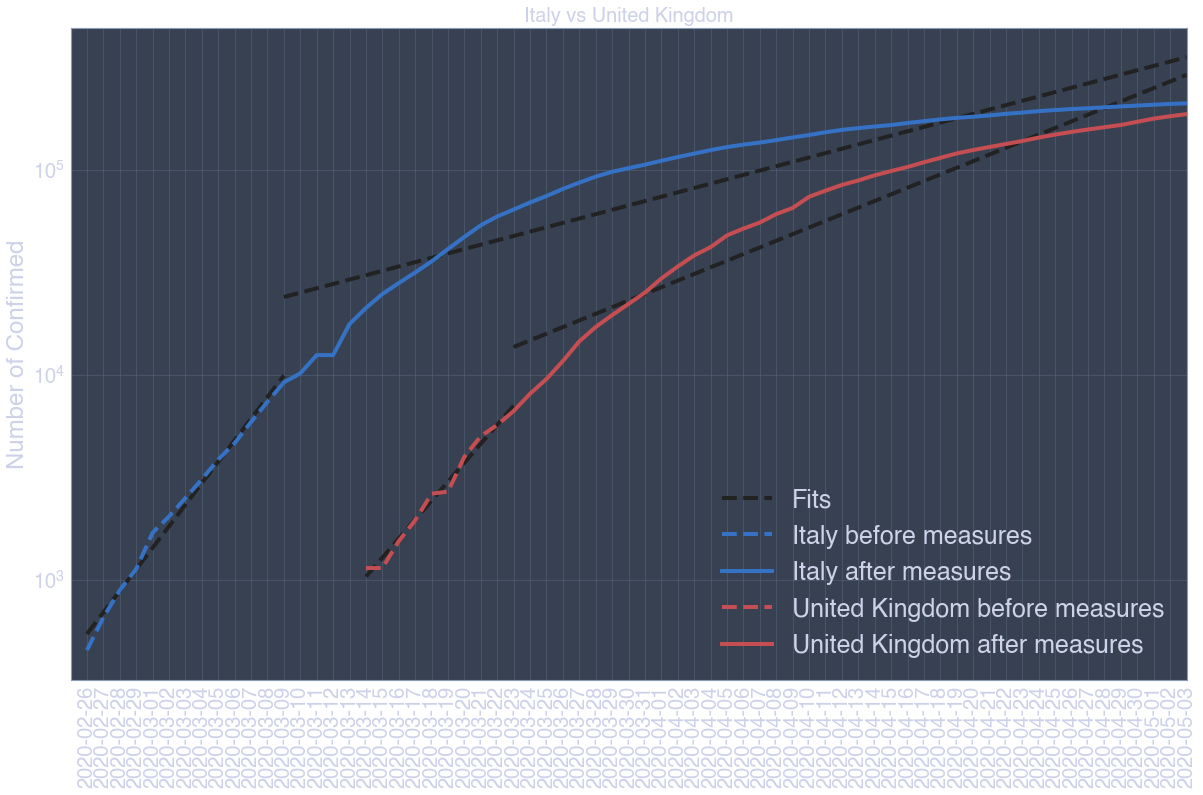

In [53]:
country1 = 'Italy'
country2 = 'United Kingdom'

x1a = foo[(foo['Province/State'] == country1) &
         (foo['Date'] <= nationwide_measures[country1])]['Date']
x1b = foo[(foo['Province/State'] == country1) &
         (foo['Date'] >= nationwide_measures[country1])]['Date']
x2a = foo[(foo['Province/State'] == country2) &
         (foo['Date'] <= nationwide_measures[country2])]['Date']
x2b = foo[(foo['Province/State'] == country2) &
         (foo['Date'] >= nationwide_measures[country2])]['Date']


y1a = foo[(foo['Province/State'] == country1) &
         (foo['Date'] <= nationwide_measures[country1])]['Confirmed']
y1b = foo[(foo['Province/State'] == country1) &
         (foo['Date'] >= nationwide_measures[country1])]['Confirmed']
y2a = foo[(foo['Province/State'] == country2) &
         (foo['Date'] <= nationwide_measures[country2])]['Confirmed']
y2b = foo[(foo['Province/State'] == country2) &
         (foo['Date'] >= nationwide_measures[country2])]['Confirmed']

# y1 = foo[foo['Province/State'] == country1]['Confirmed']
# y2 = foo[foo['Province/State'] == country2]['Confirmed']
fig, ax = plt.subplots(figsize=(20, 12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)
ax.set_xlim(np.datetime64('2020-02-25'), max(x1b))


# ________________________________________________________________________________ FITS
regressor = LinearRegression()
transformer = FunctionTransformer(np.log, validate=True)

######################a
x1a_samp = np.array(range(0, len(x1a))).reshape((-1,1))
y1a_samp = np.reshape(y1a.values, (-1, 1))
y1a_trans = transformer.fit_transform(y1a_samp)             

model = regressor.fit(x1a_samp, y1a_trans)                  
y1a_fit = model.predict(x1a_samp)
######################
x1b_samp = np.array(range(0, len(x1b))).reshape((-1,1))
y1b_samp = np.reshape(y1b.values, (-1, 1))
y1b_trans = transformer.fit_transform(y1b_samp)             

model = regressor.fit(x1b_samp, y1b_trans)                  
y1b_fit = model.predict(x1b_samp)
######################
x2a_samp = np.array(range(0, len(x2a))).reshape((-1,1))
y2a_samp = np.reshape(y2a.values, (-1, 1))
y2a_trans = transformer.fit_transform(y2a_samp)             

model = regressor.fit(x2a_samp, y2a_trans)                  
y2a_fit = model.predict(x2a_samp)
######################
x2b_samp = np.array(range(0, len(x2b))).reshape((-1,1))
y2b_samp = np.reshape(y2b.values, (-1, 1))
y2b_trans = transformer.fit_transform(y2b_samp)             

model = regressor.fit(x2b_samp, y2b_trans)                  
y2b_fit = model.predict(x2b_samp)
# ________________________________________________________________________________ FITS
ax.semilogy(x1a, np.exp(y1a_fit), '--k', linewidth = 4)
ax.semilogy(x1b, np.exp(y1b_fit), '--k', linewidth = 4)
ax.semilogy(x2a, np.exp(y2a_fit), '--k', linewidth = 4)
ax.semilogy(x2b, np.exp(y2b_fit), '--k', linewidth = 4, label = 'Fits')



ax.semilogy(x1a, y1a, '--b', linewidth = 4, label = f'{country1} before measures')
ax.semilogy(x1b, y1b, 'b', linewidth = 4, label = f'{country1} after measures')

ax.semilogy(x2a, y2a, '--r', linewidth = 4, label = f'{country2} before measures')
ax.semilogy(x2b, y2b, 'r', linewidth = 4, label = f'{country2} after measures')


ax.set_title(f'{country1} vs {country2}', fontsize = 20)
ax.set_ylabel('Number of Confirmed', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)


ax.grid(linewidth=0.6)

plt.legend(frameon=False, fontsize=25)
plt.savefig(f'{country1} vs {country2} confirmed.png', dpi = 600, bbox_inches= 'tight')

plt.show()

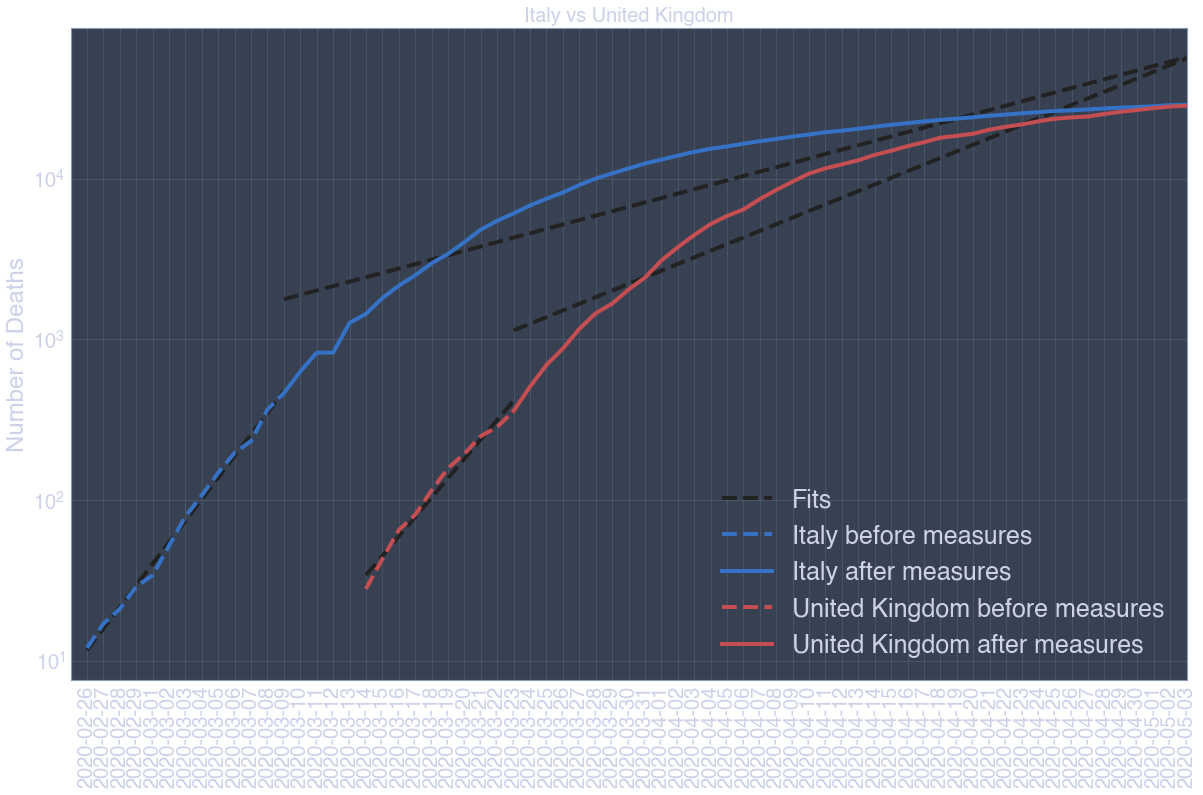

In [54]:
country1 = 'Italy'
country2 = 'United Kingdom'
foo = foo[foo['Deaths']>10]
x1a = foo[(foo['Province/State'] == country1) &
         (foo['Date'] <= nationwide_measures[country1])]['Date']
x1b = foo[(foo['Province/State'] == country1) &
         (foo['Date'] >= nationwide_measures[country1])]['Date']
x2a = foo[(foo['Province/State'] == country2) &
         (foo['Date'] <= nationwide_measures[country2])]['Date']
x2b = foo[(foo['Province/State'] == country2) &
         (foo['Date'] >= nationwide_measures[country2])]['Date']


y1a = foo[(foo['Province/State'] == country1) &
         (foo['Date'] <= nationwide_measures[country1])]['Deaths']
y1b = foo[(foo['Province/State'] == country1) &
         (foo['Date'] >= nationwide_measures[country1])]['Deaths']
y2a = foo[(foo['Province/State'] == country2) &
         (foo['Date'] <= nationwide_measures[country2])]['Deaths']
y2b = foo[(foo['Province/State'] == country2) &
         (foo['Date'] >= nationwide_measures[country2])]['Deaths']

# y1 = foo[foo['Province/State'] == country1]['Deaths']
# y2 = foo[foo['Province/State'] == country2]['Deaths']
fig, ax = plt.subplots(figsize=(20, 12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)
ax.set_xlim(np.datetime64('2020-02-25'), max(x1b))


# ________________________________________________________________________________ FITS
regressor = LinearRegression()
transformer = FunctionTransformer(np.log, validate=True)

######################a
x1a_samp = np.array(range(0, len(x1a))).reshape((-1,1))
y1a_samp = np.reshape(y1a.values, (-1, 1))
y1a_trans = transformer.fit_transform(y1a_samp)             

model = regressor.fit(x1a_samp, y1a_trans)                  
y1a_fit = model.predict(x1a_samp)
######################
x1b_samp = np.array(range(0, len(x1b))).reshape((-1,1))
y1b_samp = np.reshape(y1b.values, (-1, 1))
y1b_trans = transformer.fit_transform(y1b_samp)             

model = regressor.fit(x1b_samp, y1b_trans)                  
y1b_fit = model.predict(x1b_samp)
######################
x2a_samp = np.array(range(0, len(x2a))).reshape((-1,1))
y2a_samp = np.reshape(y2a.values, (-1, 1))
y2a_trans = transformer.fit_transform(y2a_samp)             

model = regressor.fit(x2a_samp, y2a_trans)                  
y2a_fit = model.predict(x2a_samp)
######################
x2b_samp = np.array(range(0, len(x2b))).reshape((-1,1))
y2b_samp = np.reshape(y2b.values, (-1, 1))
y2b_trans = transformer.fit_transform(y2b_samp)             

model = regressor.fit(x2b_samp, y2b_trans)                  
y2b_fit = model.predict(x2b_samp)
# ________________________________________________________________________________ FITS
ax.semilogy(x1a, np.exp(y1a_fit), '--k', linewidth = 4)
ax.semilogy(x1b, np.exp(y1b_fit), '--k', linewidth = 4)
ax.semilogy(x2a, np.exp(y2a_fit), '--k', linewidth = 4)
ax.semilogy(x2b, np.exp(y2b_fit), '--k', linewidth = 4, label = 'Fits')



ax.semilogy(x1a, y1a, '--b', linewidth = 4, label = f'{country1} before measures')
ax.semilogy(x1b, y1b, 'b', linewidth = 4, label = f'{country1} after measures')

ax.semilogy(x2a, y2a, '--r', linewidth = 4, label = f'{country2} before measures')
ax.semilogy(x2b, y2b, 'r', linewidth = 4, label = f'{country2} after measures')


ax.set_title(f'{country1} vs {country2}', fontsize = 20)
ax.set_ylabel('Number of Deaths', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)


ax.grid(linewidth=0.6)

plt.legend(frameon=False, fontsize=25)
plt.savefig(f'{country1} vs {country2} Deaths.png', dpi = 600, bbox_inches= 'tight')

plt.show()

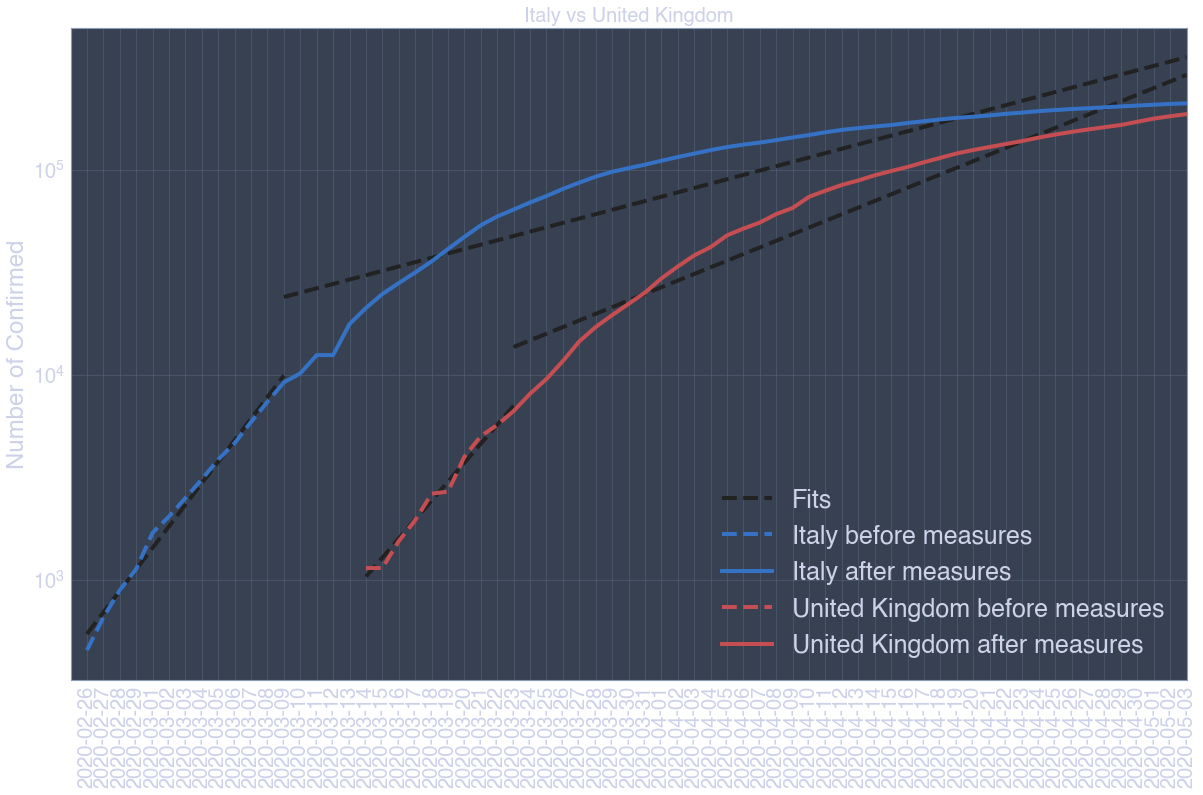

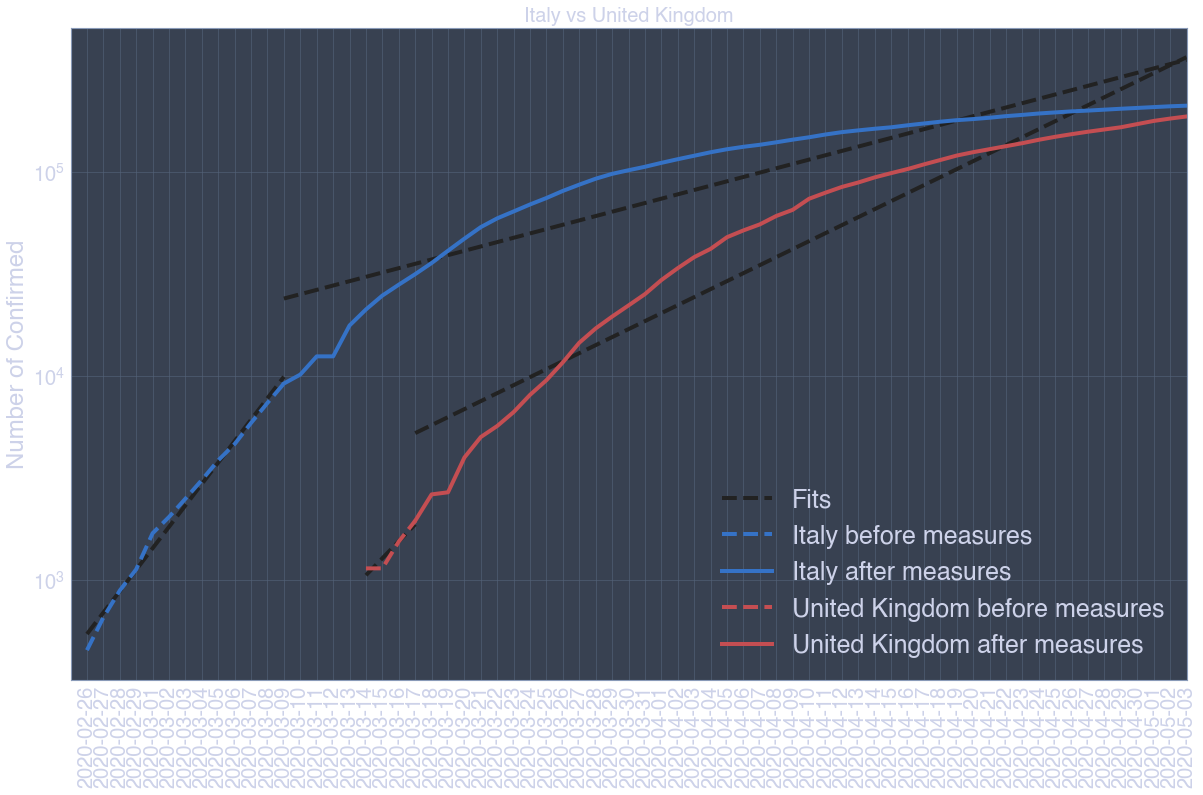

In [55]:
country1 = 'Italy'
country2 = 'United Kingdom'
metric = 'Confirmed'

if country2 in nationwide_measures.keys():
    x1a = foo[(foo['Province/State'] == country1) &
             (foo['Date'] <= nationwide_measures[country1])]['Date']
    x1b = foo[(foo['Province/State'] == country1) &
             (foo['Date'] >= nationwide_measures[country1])]['Date']
    x2a = foo[(foo['Province/State'] == country2) &
             (foo['Date'] <= nationwide_measures[country2])]['Date']
    x2b = foo[(foo['Province/State'] == country2) &
             (foo['Date'] >= nationwide_measures[country2])]['Date']


    y1a = foo[(foo['Province/State'] == country1) &
             (foo['Date'] <= nationwide_measures[country1])][metric]
    y1b = foo[(foo['Province/State'] == country1) &
             (foo['Date'] >= nationwide_measures[country1])][metric]
    y2a = foo[(foo['Province/State'] == country2) &
             (foo['Date'] <= nationwide_measures[country2])][metric]
    y2b = foo[(foo['Province/State'] == country2) &
             (foo['Date'] >= nationwide_measures[country2])][metric]

    # y1 = foo[foo['Province/State'] == country1]['Confirmed Cases']
    # y2 = foo[foo['Province/State'] == country2]['Confirmed Cases']
    fig, ax = plt.subplots(figsize=(20, 12))

    days = mdates.DayLocator()
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(days)
    ax.set_xlim(np.datetime64('2020-02-25'), max(x1b))


    # ________________________________________________________________________________ FITS
    regressor = LinearRegression()
    transformer = FunctionTransformer(np.log, validate=True)

    ######################a
    x1a_samp = np.array(range(0, len(x1a))).reshape((-1,1))
    y1a_samp = np.reshape(y1a.values, (-1, 1))
    y1a_trans = transformer.fit_transform(y1a_samp)             

    model = regressor.fit(x1a_samp, y1a_trans)                  
    y1a_fit = model.predict(x1a_samp)
    ######################
    x1b_samp = np.array(range(0, len(x1b))).reshape((-1,1))
    y1b_samp = np.reshape(y1b.values, (-1, 1))
    y1b_trans = transformer.fit_transform(y1b_samp)             

    model = regressor.fit(x1b_samp, y1b_trans)                  
    y1b_fit = model.predict(x1b_samp)
    ######################
    x2a_samp = np.array(range(0, len(x2a))).reshape((-1,1))
    y2a_samp = np.reshape(y2a.values, (-1, 1))
    y2a_trans = transformer.fit_transform(y2a_samp)             

    model = regressor.fit(x2a_samp, y2a_trans)                  
    y2a_fit = model.predict(x2a_samp)
    ######################
    x2b_samp = np.array(range(0, len(x2b))).reshape((-1,1))
    y2b_samp = np.reshape(y2b.values, (-1, 1))
    y2b_trans = transformer.fit_transform(y2b_samp)             

    model = regressor.fit(x2b_samp, y2b_trans)                  
    y2b_fit = model.predict(x2b_samp)
    # ________________________________________________________________________________ FITS
    ax.semilogy(x1a, np.exp(y1a_fit), '--k', linewidth = 4)
    ax.semilogy(x1b, np.exp(y1b_fit), '--k', linewidth = 4)
    ax.semilogy(x2a, np.exp(y2a_fit), '--k', linewidth = 4)
    ax.semilogy(x2b, np.exp(y2b_fit), '--k', linewidth = 4, label = 'Fits')



    ax.semilogy(x1a, y1a, '--b', linewidth = 4, label = f'{country1} before measures')
    ax.semilogy(x1b, y1b, 'b', linewidth = 4, label = f'{country1} after measures')

    ax.semilogy(x2a, y2a, '--r', linewidth = 4, label = f'{country2} before measures')
    ax.semilogy(x2b, y2b, 'r', linewidth = 4, label = f'{country2} after measures')


    ax.set_title(f'{country1} vs {country2}', fontsize = 20)
    ax.set_ylabel(f'Number of {metric}', fontsize = 24)
    ax.tick_params(axis = 'x', labelsize=20, rotation=90)
    ax.tick_params(axis = 'y', labelsize=20)
    ax.set_xticks(x4)


    ax.grid(linewidth=0.6)

    plt.legend(frameon=False, fontsize=25)
    plt.savefig(f'{country1} vs {country2} {metric}.png', dpi = 600, bbox_inches= 'tight')

    plt.show()

if country2 in minor_measures.keys():
    x1a = foo[(foo['Province/State'] == country1) &
         (foo['Date'] <= nationwide_measures[country1])]['Date']
    x1b = foo[(foo['Province/State'] == country1) &
             (foo['Date'] >= nationwide_measures[country1])]['Date']
    x2a = foo[(foo['Province/State'] == country2) &
             (foo['Date'] <= minor_measures[country2])]['Date']
    x2b = foo[(foo['Province/State'] == country2) &
             (foo['Date'] >= minor_measures[country2])]['Date']


    y1a = foo[(foo['Province/State'] == country1) &
             (foo['Date'] <= nationwide_measures[country1])][metric]
    y1b = foo[(foo['Province/State'] == country1) &
             (foo['Date'] >= nationwide_measures[country1])][metric]
    y2a = foo[(foo['Province/State'] == country2) &
             (foo['Date'] <= minor_measures[country2])][metric]
    y2b = foo[(foo['Province/State'] == country2) &
             (foo['Date'] >= minor_measures[country2])][metric]

    # y1 = foo[foo['Province/State'] == country1]['Confirmed Cases']
    # y2 = foo[foo['Province/State'] == country2]['Confirmed Cases']
    fig, ax = plt.subplots(figsize=(20, 12))

    days = mdates.DayLocator()
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(days)
    ax.set_xlim(np.datetime64('2020-02-25'), max(x1b))


    # ________________________________________________________________________________ FITS
    regressor = LinearRegression()
    transformer = FunctionTransformer(np.log, validate=True)

    ######################a
    x1a_samp = np.array(range(0, len(x1a))).reshape((-1,1))
    y1a_samp = np.reshape(y1a.values, (-1, 1))
    y1a_trans = transformer.fit_transform(y1a_samp)             

    model = regressor.fit(x1a_samp, y1a_trans)                  
    y1a_fit = model.predict(x1a_samp)
    ######################
    x1b_samp = np.array(range(0, len(x1b))).reshape((-1,1))
    y1b_samp = np.reshape(y1b.values, (-1, 1))
    y1b_trans = transformer.fit_transform(y1b_samp)             

    model = regressor.fit(x1b_samp, y1b_trans)                  
    y1b_fit = model.predict(x1b_samp)
    ######################
    x2a_samp = np.array(range(0, len(x2a))).reshape((-1,1))
    y2a_samp = np.reshape(y2a.values, (-1, 1))
    y2a_trans = transformer.fit_transform(y2a_samp)             

    model = regressor.fit(x2a_samp, y2a_trans)                  
    y2a_fit = model.predict(x2a_samp)
    ######################
    x2b_samp = np.array(range(0, len(x2b))).reshape((-1,1))
    y2b_samp = np.reshape(y2b.values, (-1, 1))
    y2b_trans = transformer.fit_transform(y2b_samp)             

    model = regressor.fit(x2b_samp, y2b_trans)                  
    y2b_fit = model.predict(x2b_samp)
    # ________________________________________________________________________________ FITS
    ax.semilogy(x1a, np.exp(y1a_fit), '--k', linewidth = 4)
    ax.semilogy(x1b, np.exp(y1b_fit), '--k', linewidth = 4)
    ax.semilogy(x2a, np.exp(y2a_fit), '--k', linewidth = 4)
    ax.semilogy(x2b, np.exp(y2b_fit), '--k', linewidth = 4, label = 'Fits')



    ax.semilogy(x1a, y1a, '--b', linewidth = 4, label = f'{country1} before measures')
    ax.semilogy(x1b, y1b, 'b', linewidth = 4, label = f'{country1} after measures')

    ax.semilogy(x2a, y2a, '--r', linewidth = 4, label = f'{country2} before measures')
    ax.semilogy(x2b, y2b, 'r', linewidth = 4, label = f'{country2} after measures')


    ax.set_title(f'{country1} vs {country2}', fontsize = 20)
    ax.set_ylabel(f'Number of {metric}', fontsize = 24)
    ax.tick_params(axis = 'x', labelsize=20, rotation=90)
    ax.tick_params(axis = 'y', labelsize=20)
    ax.set_xticks(x4)


    ax.grid(linewidth=0.6)

    plt.legend(frameon=False, fontsize=25)
    plt.savefig(f'{country1} vs {country2} {metric}.png', dpi = 600, bbox_inches= 'tight')

    plt.show()

In [56]:
foo.head()

,Province/State,Country/Region,Date,Lat,Long,Confirmed,Recovered,Deaths,ConfirmedDaily,DeathsDaily,RecoveredDaily,MonthYear,Continent,DeathRate,RecoveredRate
75,Afghanistan,Afghanistan,2020-04-06,33.0,65.0,367.0,18.0,11.0,18.0,4.0,3.0,Apr-2020,Asia,0.029973,0.049046
76,Afghanistan,Afghanistan,2020-04-07,33.0,65.0,423.0,18.0,14.0,56.0,3.0,0.0,Apr-2020,Asia,0.033097,0.042553
77,Afghanistan,Afghanistan,2020-04-08,33.0,65.0,444.0,29.0,14.0,21.0,0.0,11.0,Apr-2020,Asia,0.031532,0.065315
78,Afghanistan,Afghanistan,2020-04-09,33.0,65.0,484.0,32.0,15.0,40.0,1.0,3.0,Apr-2020,Asia,0.030992,0.066116
79,Afghanistan,Afghanistan,2020-04-10,33.0,65.0,521.0,32.0,15.0,37.0,0.0,0.0,Apr-2020,Asia,0.028791,0.061420


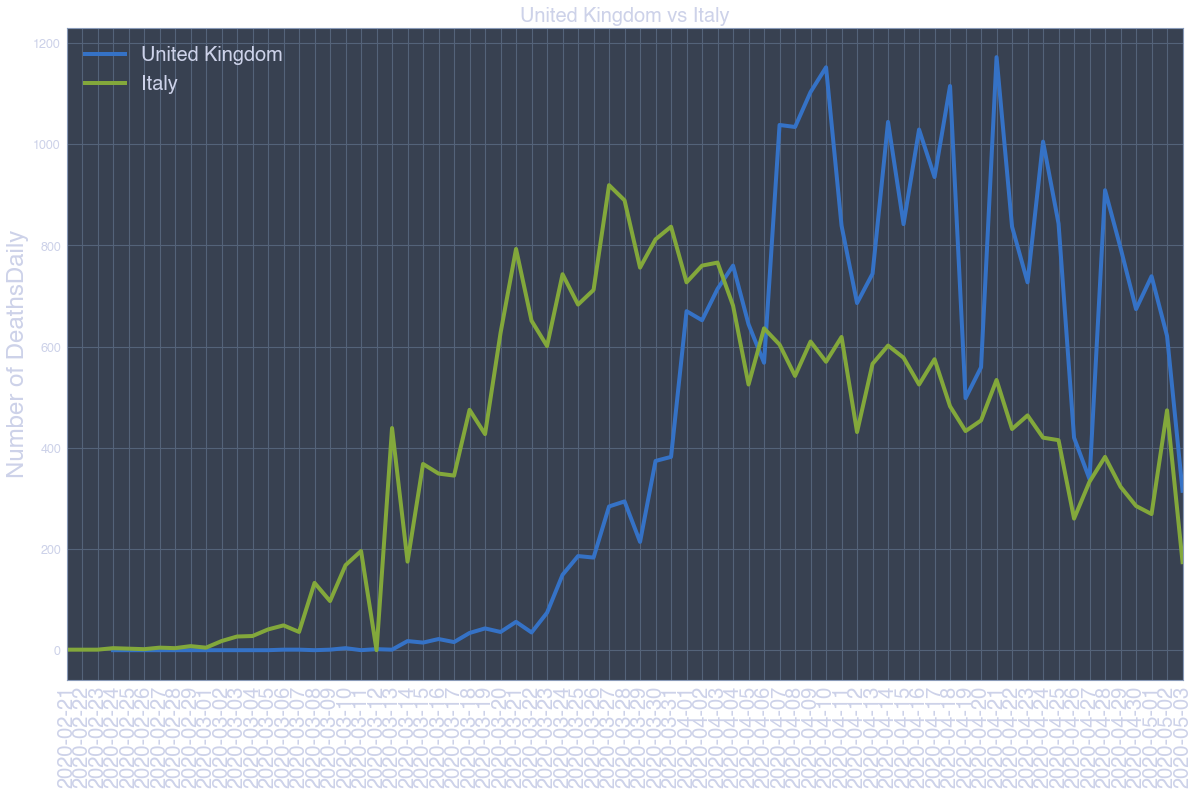

In [57]:
foo = df3[df3['Confirmed'] > 10]
x3 = foo[foo['Province/State'] == 'United Kingdom']['Date']
x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'United Kingdom']['DeathsDaily']
y4 = foo[foo['Province/State'] == 'Italy']['DeathsDaily']

fig, ax = plt.subplots(figsize = (20,12))


ax.set_xlim(np.datetime64('2020-02-25'), max(x4))


ax.plot(x3, y3, linewidth=4, label = 'United Kingdom')
ax.plot(x4, y4, linewidth=4, label = 'Italy')


ax.set_title('United Kingdom vs Italy', fontsize = 20)
ax.set_ylabel('Number of DeathsDaily', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.set_xticks(x4)


plt.legend(frameon=False, fontsize=20)

plt.show()

NameError: name 'y_hat' is not defined

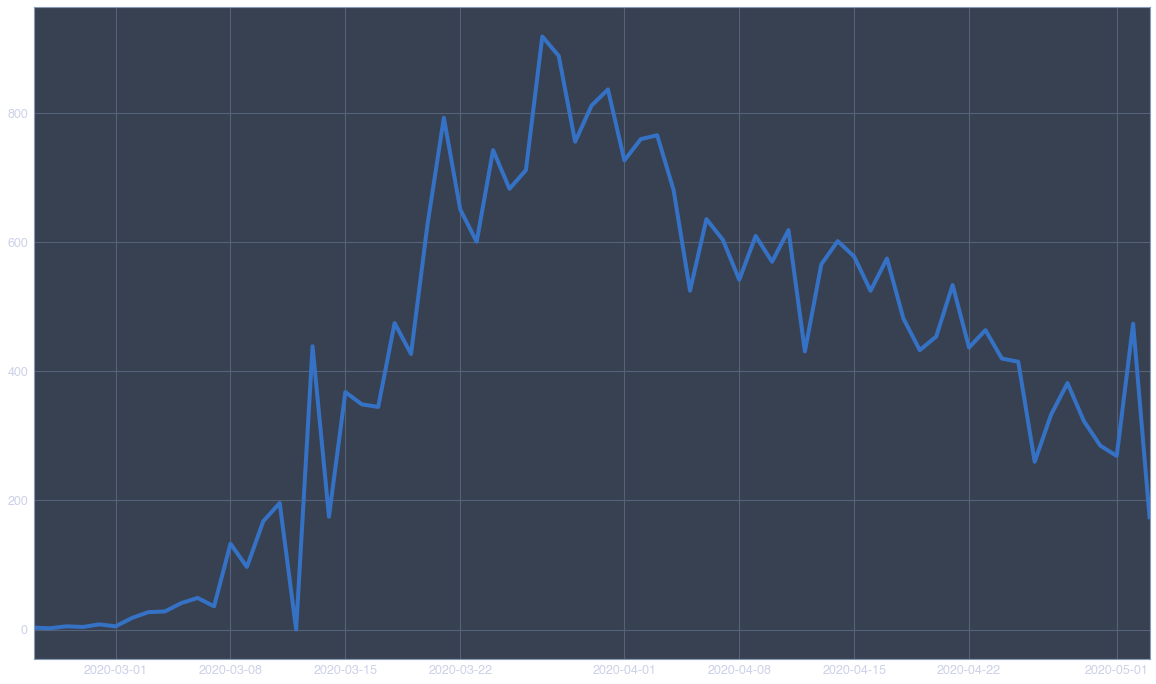

In [58]:
foo = df3[df3['Confirmed'] > 10]
# x3 = foo[foo['Province/State'] == 'United Kingdom']['Date']
x4 = foo[foo['Province/State'] == 'Italy']['Date']

# y3 = foo[foo['Province/State'] == 'United Kingdom']['DeathsDaily']
y4 = foo[foo['Province/State'] == 'Italy']['DeathsDaily']

fig, ax = plt.subplots(figsize = (20,12))


ax.set_xlim(np.datetime64('2020-02-25'), max(x4))


# ax.plot(x3, y3, linewidth=4, label = 'United Kingdom')
ax.plot(x4, y4, linewidth=4, label = 'Italy')
ax.plot(x4, y_hat)


ax.set_title('United Kingdom vs Italy', fontsize = 20)
ax.set_ylabel('Number of DeathsDaily', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.set_xticks(x4)


plt.legend(frameon=False, fontsize=20)

plt.show()

In [ ]:
y_values =  foo[foo['Province/State'] == 'Italy']['DeathsDaily']
x_values = np.linspace(0,1, len(foo[foo['Province/State'] == 'Italy']['Date']))
poly_degree = 3
coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)

In [ ]:
df3.to_clipboard()

In [67]:
N, b, g = [10, 100, 1000], [0.1, 0.5, 1.0], [0.2, 0.6, 1.2]

In [70]:
a = [N, b, g]

In [68]:
a = {N:[10, 100, 1000],b:[0.1, 0.5, 1.0], g:[0.2, 0.6, 1.2]}
    

TypeError: unhashable type: 'list'

In [ ]:
a.

In [74]:
for val in a:
    for param in val:
        print(val.name, param)

AttributeError: 'list' object has no attribute 'name'